In [1]:
#headers
import os
import csv
import json
import datetime
import requests
import numpy as np
import pandas as pd
import urllib.parse
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Getting the data from iexpis.com

In [2]:
#get data from iexcloud
class create_csv:
    '''
    Class to get and save file
    
    This class will get the data from api as json and then save it as a csv
    
    Attributes
    ----------
    
    dates = list
        This will save dates from the json file recieved and store it as a list
        
    closing = list
        this will save the closing price of the particular stock in a list
        
    filename = None
        the name of the file which is to be stored is defined here
        
    Methods
    -------
    
    lookup(self, symbol, time)
        Check for the API and return date and closing price
    
    make_csv(self, filename)
        It hepls in making csv file from the api data we gattered 
    
    '''
    
    def __init__(self):
        '''
        Parameters
        ----------
        
        dates = list
            This will save dates from the json file recieved and store it as a list
        
        closing = list
            this will save the closing price of the particular stock in a list
        
        filename = None
            the name of the file which is to be stored is defined here
        '''
        
        self.dates = []
        self.closing = []
        self.filename = None
        
    def lookup(self, symbol, time):
        '''
        check for the API and return date and closing price
        
        This method will check for the closing price and date and will return the them as json and it will convert it into 
        tow seperate list.
        
        Parameters
        ----------
        
        symbol = str
            will take the NASDAQ symbol as input.
            
        time = str 
            time is in months (format like 5m).
            
        Raises
        ------
        
        KeyError
            return None
            
        TypeError
            it occurs when the data type of the object in an operation is inappropriate
            
        ValueError
            return None
        '''

        # Contact API
        try:
            api_key = os.environ.get("API_KEY")
            url = f"https://cloud.iexapis.com/stable/stock/{urllib.parse.quote_plus(symbol)}/chart/{urllib.parse.quote_plus(time)}?token=pk_6cf34855c2da4a45b291d31d00e99ee6"
            response = requests.get(url)
            response.raise_for_status()

        except requests.RequestException:
            return None

        # Parse response
        try:
            quote = response.json()
            for i in range(len(quote)):
                self.dates.append(quote[i]['priceDate'])
                self.closing.append(quote[i]['close'])

        except (KeyError, TypeError, ValueError):
            return None

    def make_csv(self, filename):
        '''
        Make CSV in the current directory
        
        this function is called to make csv in the current directory and save the dates and closing to that CSV
        
        Parameters
        ----------
        
        filename: str
            the name of the file which has to be saved in the current directory
            
        '''
        
        self.filename = filename
        
        # creating csv file from the api data
        with open(f'{self.filename}.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerows(list(zip(self.dates, self.closing)))
        
        return self.filename
            

In [3]:
cd

C:\Users\otiwa


In [4]:
# the parameter for the class create_csv are here
stock_name = input("Enter the name of stock: ")
months = input("Enter the months to take in dataset: ")
file_name = input("Enter the name of csv file: ")

Enter the name of stock: googl
Enter the months to take in dataset: 4m
Enter the name of csv file: googl


In [5]:
# the class create csv is here
cc = create_csv()
cc.lookup(stock_name, months)
cc.make_csv(file_name)

'googl'

In [6]:
# converting it to panda date time 
df = pd.read_csv(f'{file_name}.csv', index_col=0, parse_dates=True, header=None)
df.index = pd.DatetimeIndex(df.index)


In [7]:
df

,1
0,
2022-07-19,113.81
2022-07-20,113.90
2022-07-21,114.34
2022-07-22,107.90
2022-07-25,107.51
...,...
2022-11-14,95.70
2022-11-15,98.44
2022-11-16,98.85


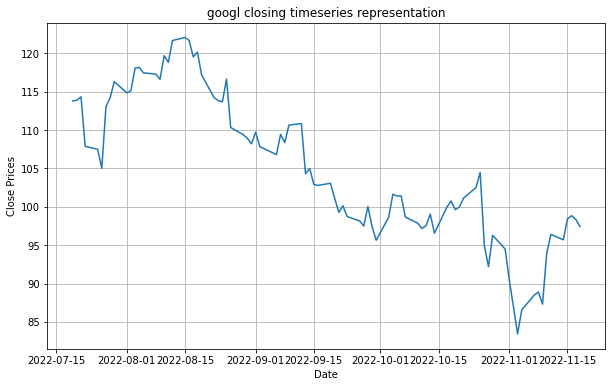

In [8]:
#plotting the file saved in the current directory
rcParams['figure.figsize'] = 16, 9
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df[1])
plt.title(f'{stock_name} closing timeseries representation')
plt.show()

In [9]:
#splitting the data into training and testing 
df_train = df[:-int(df.shape[0] * 0.33)]
df_test = df[-int(df.shape[0] * 0.33):]

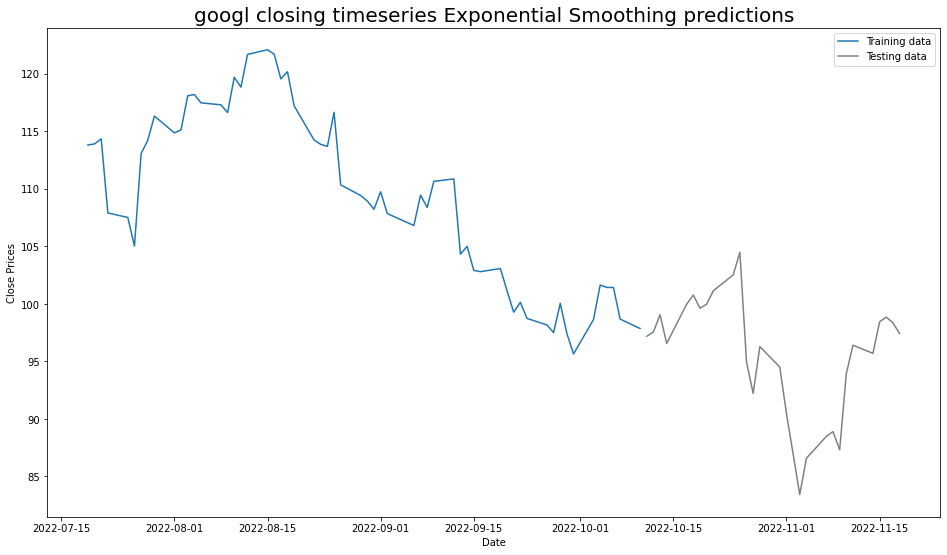

In [11]:
#plotting the training and testing data
plt.title(f'{stock_name} closing timeseries Exponential Smoothing predictions', size=20)
plt.plot(df_train[1], label='Training data')
plt.plot(df_test[1], color='gray', label='Testing data')
plt.xlabel('Date')
plt.ylabel('Close Prices')

plt.legend();

# prediction using simple exponential smoothing 

C:\Users\otiwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\otiwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


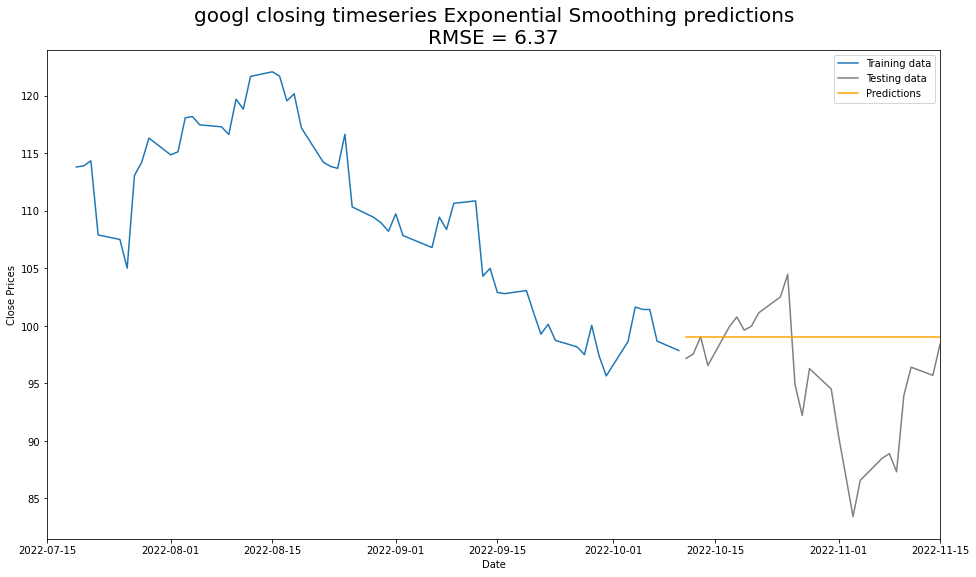

In [12]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Model parameters
span = 4 
alpha = 2 / (span + 1)

# Train the model
model = SimpleExpSmoothing(df_train[1])
results = model.fit(smoothing_level=alpha, optimized=False)
predictions = results.forecast(steps=df_test.shape[0])

# Evaluate
rmse = mean_squared_error(df_test[1], predictions, squared=False)

# Plot
ax = plt.subplots()
plt.title(f'{stock_name} closing timeseries Exponential Smoothing predictions\nRMSE = {np.round(rmse, 2)}', size=20)
plt.plot(df_train[1], label='Training data')
plt.plot(df_test[1], color='gray', label='Testing data')
plt.xlim([datetime.date(2022, 7, 15), datetime.date(2022, 11, 15)])
plt.plot(df_test.index, predictions.values, color='orange', label='Predictions')
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.legend();

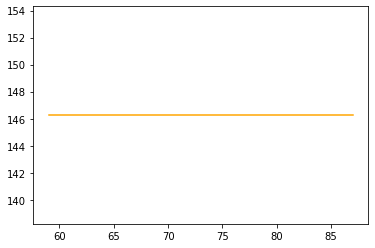

In [81]:
plt.plot(predictions, color='orange', label='Predictions')
plt.show()

# preditction using double exponential smoothing

double exponenetial smoothing using Additive trend

C:\Users\otiwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\otiwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


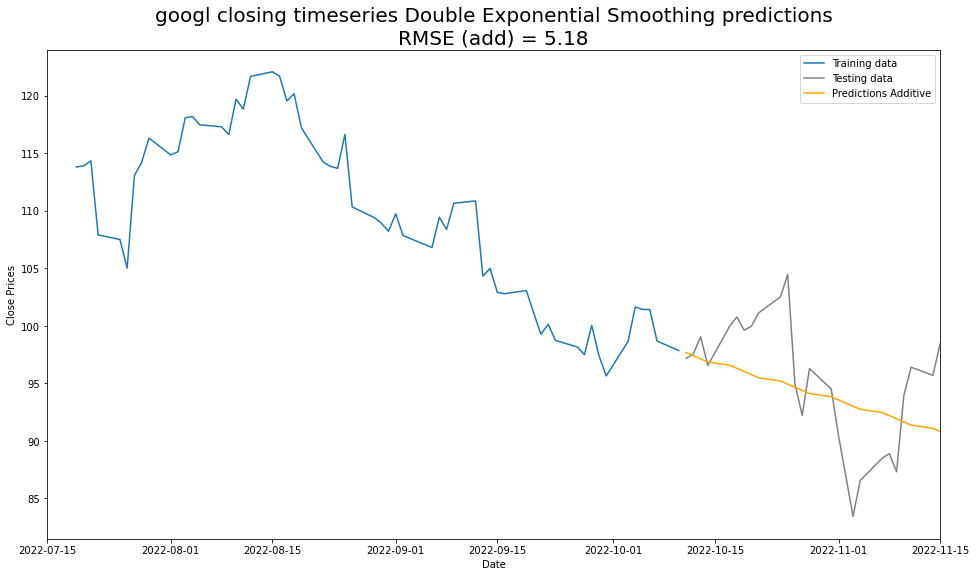

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Additive model
model_add = ExponentialSmoothing(df_train[1], trend='add')
results_add = model_add.fit()
predictions_add = results_add.forecast(steps=df_test.shape[0])

rmse_add = mean_squared_error(df_test[1], predictions_add, squared=False)

# Plot
plt.title(f'{stock_name} closing timeseries Double Exponential Smoothing predictions\nRMSE (add) = {np.round(rmse_add, 2)}', size=20)
plt.plot(df_train[1], label='Training data')
plt.plot(df_test[1], color='gray', label='Testing data')
plt.xlim([datetime.date(2022, 7, 15), datetime.date(2022, 11, 15)])
plt.plot(df_test.index, predictions_add.values, color='orange', label='Predictions Additive')
# plt.plot(predictions_add, color='orange', label='Predictions Additive')
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.legend();

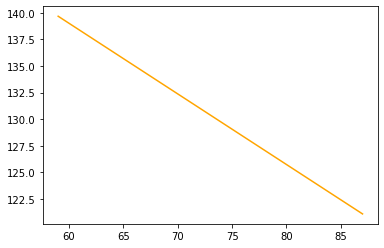

In [87]:
plt.plot(predictions_add, color='orange', label='Predictions Additive')
plt.show()

double exponenetial smoothing using Multiplicative trend

C:\Users\otiwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\otiwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


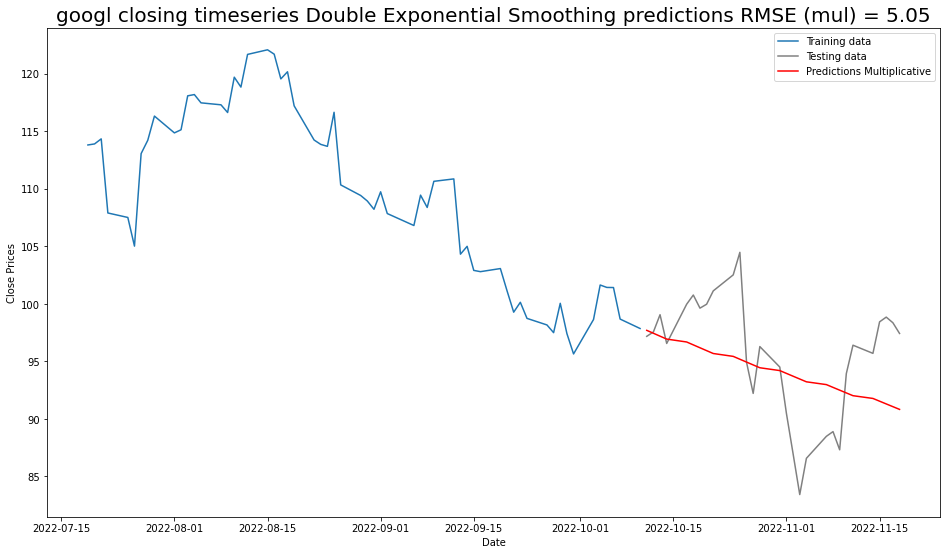

In [14]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Multiplicative model
model_mul = ExponentialSmoothing(df_train[1], trend='mul')
results_mul = model_mul.fit()
predictions_mul = results_mul.forecast(steps=df_test.shape[0])

rmse_mul = mean_squared_error(df_test[1], predictions_mul, squared=False)

# Plot
plt.title(f'{stock_name} closing timeseries Double Exponential Smoothing predictions RMSE (mul) = {np.round(rmse_mul, 2)}', size=20)
plt.plot(df_train[1], label='Training data')
plt.plot(df_test[1], color='gray', label='Testing data')
# plt.plot(predictions_mul, color='red', label='Predictions Multiplicative')
plt.plot(df_test.index, predictions_mul.values, color='red', label='Predictions Multiplicative')
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.legend();

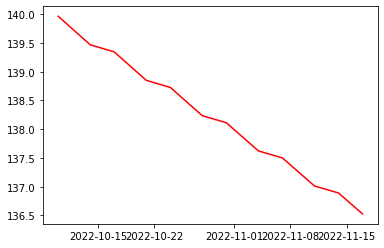

In [100]:
plt.plot(df_test.index, predictions_mul.values, color='red', label='Predictions Multiplicative')
plt.show()

# Prediction Using triple exponential smoothing 

triple exponential smoothing using additive trends

C:\Users\otiwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\otiwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


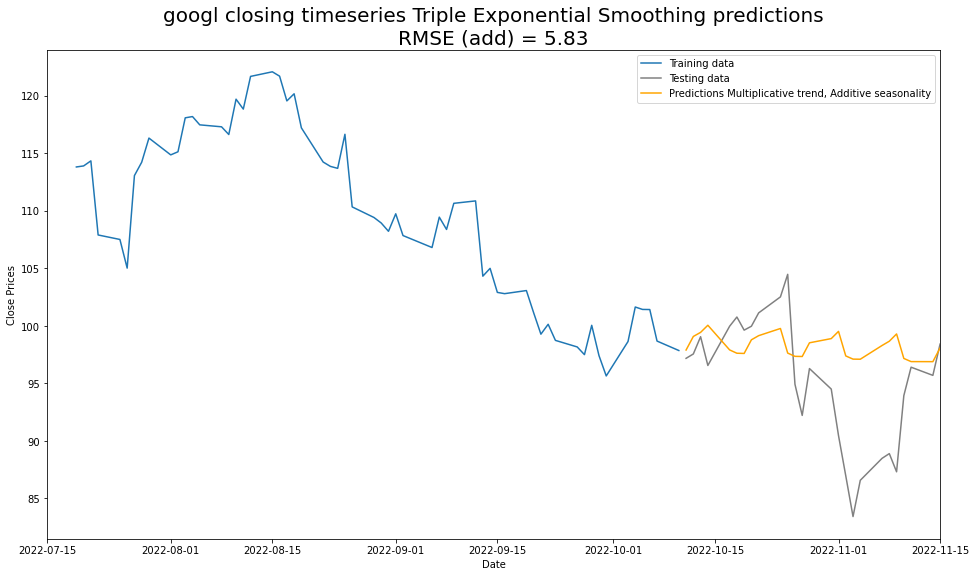

In [25]:
# Multiplicative trend / Additive seasonality model
model_mul_add = ExponentialSmoothing(df_train[1], trend='mul', seasonal='add', seasonal_periods=6)
results_mul_add = model_mul_add.fit()
predictions_mul_add = results_mul_add.forecast(steps=df_test.shape[0])

# Evaluate
rmse_mul_add = mean_squared_error(df_test[1], predictions_mul_add, squared=False)

# Plot
plt.title(f'{stock_name} closing timeseries Triple Exponential Smoothing predictions\nRMSE (add) = {np.round(rmse_mul_add, 2)}', size=20)
plt.plot(df_train[1], label='Training data')
plt.plot(df_test[1], color='gray', label='Testing data')
plt.plot(df_test.index, predictions_mul_add.values, color='orange', label='Predictions Multiplicative trend, Additive seasonality')
plt.xlim([datetime.date(2022, 7, 15), datetime.date(2022, 11, 15)])
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.legend();

triple exponential smoothing using Multiplicative trends

C:\Users\otiwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\otiwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


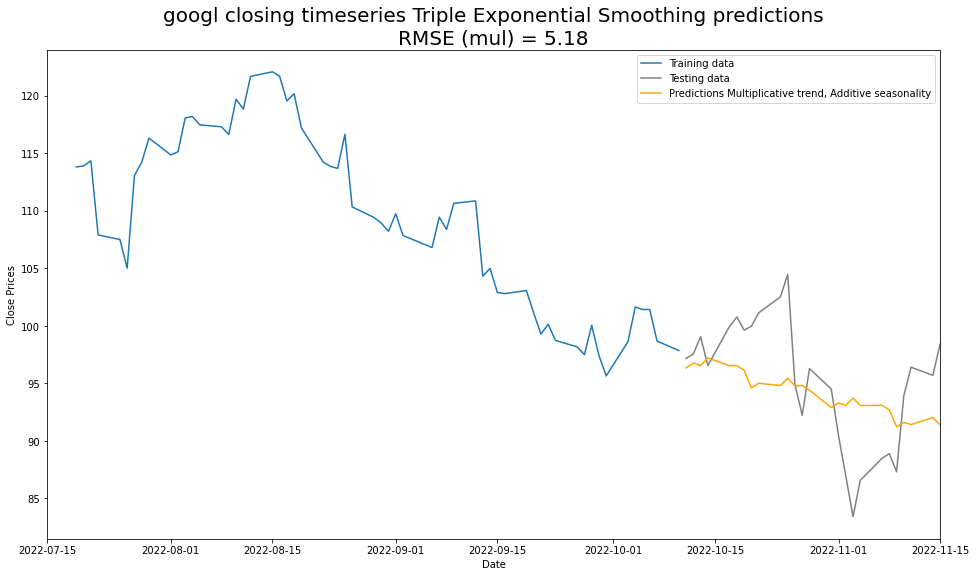

In [29]:
# Multiplicative trend / Multiplicative seasonality model
model_mul_mul = ExponentialSmoothing(df_train[1], trend='mul', seasonal='mul', seasonal_periods=7)
results_mul_mul = model_mul_mul.fit()
predictions_mul_mul = results_mul_mul.forecast(steps=df_test.shape[0])

# Evaluate
rmse_mul_mul = mean_squared_error(df_test[1], predictions_mul_mul, squared=False)

# Plot
plt.title(f'{stock_name} closing timeseries Triple Exponential Smoothing predictions\nRMSE (mul) = {np.round(rmse_mul_mul, 2)}', size=20)
plt.plot(df_train[1], label='Training data')
plt.plot(df_test[1], color='gray', label='Testing data')
plt.plot(df_test.index, predictions_mul_mul.values, color='orange', label='Predictions Multiplicative trend, Additive seasonality')
plt.xlim([datetime.date(2022, 7, 15), datetime.date(2022, 11, 15)])
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.legend();

# the best forcasting result vs actual result

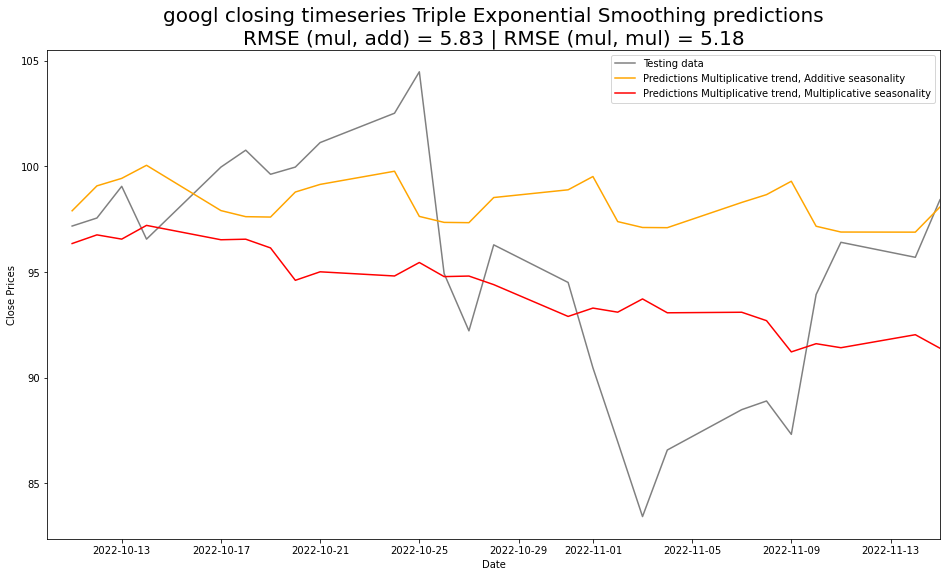

In [30]:
plt.title(f'{stock_name} closing timeseries Triple Exponential Smoothing predictions\nRMSE (mul, add) = {np.round(rmse_mul_add, 2)} | RMSE (mul, mul) = {np.round(rmse_mul_mul, 2)}', size=20)
plt.plot(df_test[1], color='gray', label='Testing data')
plt.plot(df_test.index, predictions_mul_add.values, color='orange', label='Predictions Multiplicative trend, Additive seasonality')
plt.plot(df_test.index, predictions_mul_mul.values, color='red', label='Predictions Multiplicative trend, Multiplicative seasonality')
plt.xlim([datetime.date(2022, 10, 10), datetime.date(2022, 11, 15)])
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.legend();